# Lab 4. ConvNets 


## Load data 

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize': (20, 6)})

In [32]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


In [33]:
import cv2 as cv
from tqdm import tqdm

from tensorflow import keras

In [72]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [73]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [74]:
x_train = x_train / 255.0
x_test = x_test / 255.0

In [36]:
y_train

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [37]:
y_train_ohe = keras.utils.to_categorical(y_train, dtype="uint8")
y_test_ohe = keras.utils.to_categorical(y_test, dtype="uint8")

In [38]:
y_train_ohe.shape, y_test_ohe.shape

((60000, 10), (10000, 10))

In [39]:
labels = {
    0:	"T-shirt/top",
    1:	"Trouser",
    2:	"Pullover",
    3:	"Dress",
    4:	"Coat",
    5:	"Sandal",
    6:	"Shirt",
    7:	"Sneaker",
    8:	"Bag",
    9:	"Ankle boot",
}

In [66]:
def plot_sample(X, y, labels, y_true=None):
    n = len(X)
    nrows = int((n+3) / 4)
    for i in range(n):
        ax = plt.subplot(nrows, 4, i + 1)
        ax.imshow(X[i], cmap='gray')
        title = labels[y[i]]
        if y_true is not None:
            title += f" (true is {labels[y_true[i]]})"
        ax.set_title(title)
    plt.tight_layout()

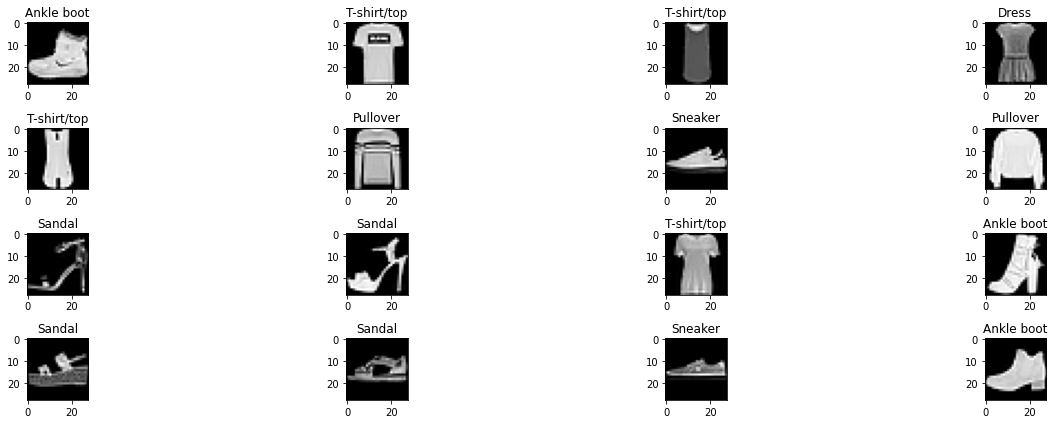

In [75]:
plot_sample(x_train[:16], y_train[:16], labels)

## Dense NN 

In [76]:
from keras import layers

In [91]:
model = keras.Sequential()

s = 28
model.add(layers.InputLayer((s, s)))
model.add(layers.Flatten())
model.add(layers.Dense(28 * 28, activation='relu'))
model.add(layers.Dense(28 * 28, activation='relu'))
model.add(layers.Dense(10, activation='sigmoid'))

In [92]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 784)               615440    
                                                                 
 dense_13 (Dense)            (None, 784)               615440    
                                                                 
 dense_14 (Dense)            (None, 10)                7850      
                                                                 
Total params: 1,238,730
Trainable params: 1,238,730
Non-trainable params: 0
_________________________________________________________________


In [93]:
model.compile(optimizer='adamax', loss=keras.losses.CategoricalCrossentropy())

In [94]:
result = model.fit(x_train, y_train_ohe, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.4790 - val_loss: 0.3933
Epoch 2/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3567 - val_loss: 0.3701
Epoch 3/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3159 - val_loss: 0.3434
Epoch 4/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2895 - val_loss: 0.3338
Epoch 5/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2677 - val_loss: 0.3130
Epoch 6/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2508 - val_loss: 0.3284
Epoch 7/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2346 - val_loss: 0.3018
Epoch 8/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2194 - val_loss: 0.2959
Epoch 9/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2072 - val_loss: 0.3181
Epoch 10/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.196

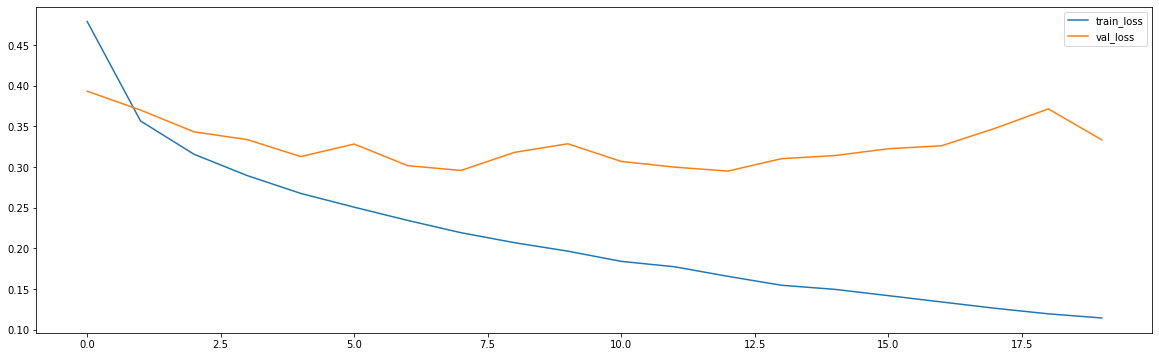

In [95]:
plt.plot(result.history['loss'], label='train_loss')
plt.plot(result.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

Since train loss is monotonically decreasing to zero, meanwhile validation loss seems to remain at the level ~0.3, we can observe signs of overfitting

In [82]:
from sklearn.metrics import accuracy_score

In [83]:
models_info = []

In [84]:
y_train_pred = np.argmax(model.predict(x_train), axis=1)
y_test_pred = np.argmax(model.predict(x_test), axis=1)

info = {}
info['model'] = "Dense"
info['acc_train'] = accuracy_score(y_train, y_train_pred)
info['acc_test'] = accuracy_score(y_test, y_test_pred)

models_info.append(info)

In [85]:
pd.DataFrame(models_info)

,model,acc_train,acc_test
0,Dense,0.924833,0.8872


Sample accuracy: 1.0


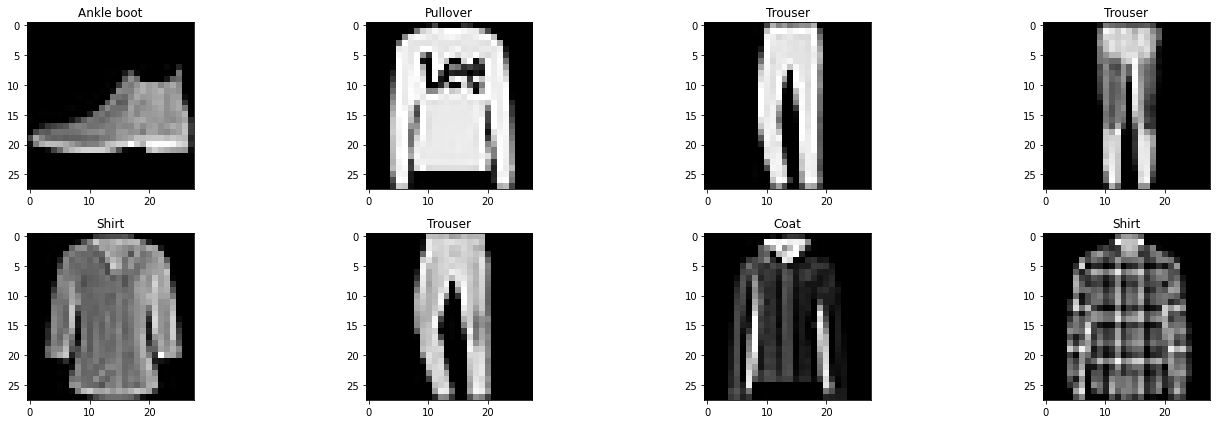

In [86]:
plot_sample(x_test[:8], y_test_pred[:8], labels)
print(f"Sample accuracy: {accuracy_score(y_test[:8], y_test_pred[:8])}")

Lets take a look at the wrong recognized images

Sample accuracy: 0.0


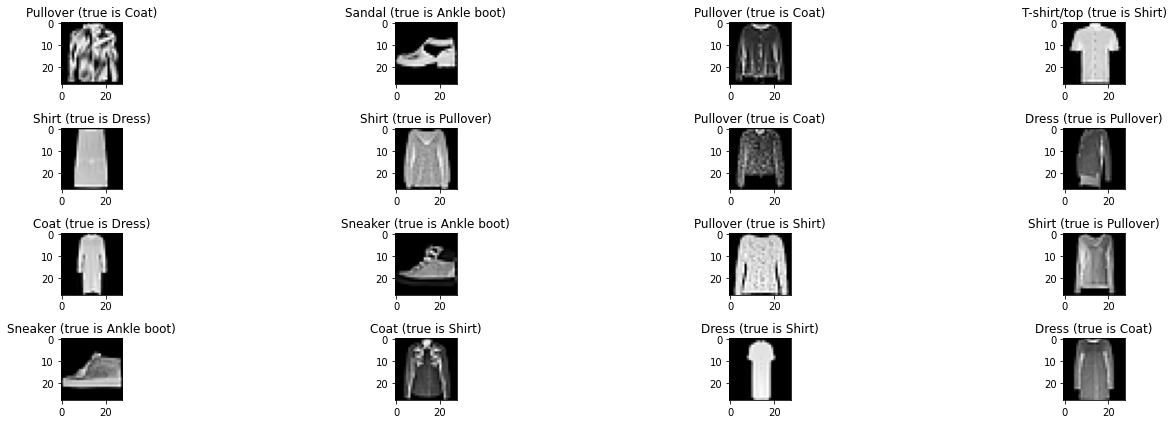

In [87]:
ind = y_test != y_test_pred
x_test_wrong = x_test[ind]
plot_sample(x_test_wrong[:16], y_test_pred[ind][:16], labels, y_test[ind][:16])
print(f"Sample accuracy: {accuracy_score(y_test[ind][:16], y_test_pred[ind][:16])}")

## LeNet-5

In [103]:
model = keras.Sequential()

model.add(layers.InputLayer((s, s, 1)))
model.add(layers.Conv2D(6, kernel_size=5, 
                        activation="tanh", padding='same', strides=1))
model.add(layers.MaxPool2D())
model.add(layers.Conv2D(16, kernel_size=5, activation='tanh', 
                        padding='valid', strides=1))
model.add(layers.MaxPool2D())
model.add(layers.Conv2D(120, kernel_size=5, activation='tanh',
                        padding='valid', strides=1))
model.add(layers.Flatten())
model.add(layers.Dense(84, activation='tanh'))
model.add(layers.Dense(10, activation='softmax'))

In [104]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 28, 28, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 6)        0         
 )                                                               
                                                                 
 conv2d_11 (Conv2D)          (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 1, 1, 120)         48120     
                                                                 
 flatten_7 (Flatten)         (None, 120)             

In [106]:
model.compile(optimizer='adam', loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [110]:
result = model.fit(x_train, y_train_ohe, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3621 - accuracy: 0.8674 - val_loss: 0.3697 - val_accuracy: 0.8624
Epoch 2/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3051 - accuracy: 0.8878 - val_loss: 0.2988 - val_accuracy: 0.8913
Epoch 3/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2718 - accuracy: 0.9003 - val_loss: 0.2950 - val_accuracy: 0.8916
Epoch 4/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2464 - accuracy: 0.9086 - val_loss: 0.2756 - val_accuracy: 0.9003
Epoch 5/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2267 - accuracy: 0.9163 - val_loss: 0.2809 - val_accuracy: 0.8953
Epoch 6/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2078 - accuracy: 0.9216 - val_loss: 0.2870 - val_accuracy: 0.8974
Epoch 7/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1924 - accuracy: 0.9277 - val_loss: 0.2730 - val_accuracy:

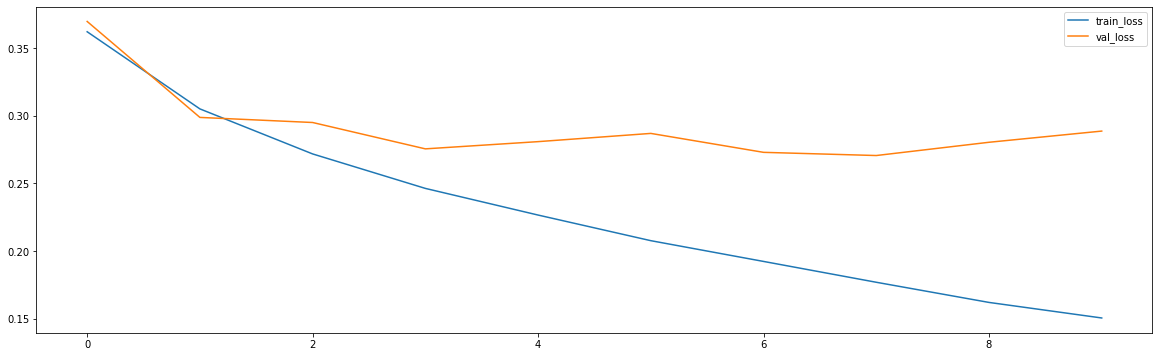

In [112]:
plt.plot(result.history['loss'], label='train_loss')
plt.plot(result.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

Here we can see again the same signs of overfitting , but with much smaller NN with convolutional layers.